In [ ]:
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langchain_openrouter import ChatOpenRouter
from langchain_core.messages import AIMessage, HumanMessage,BaseMessage
from langgraph.graph.message import add_messages

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
import requests
import random

In [34]:
load_dotenv()

True

In [ ]:
llm = ChatOpenRouter(
    model="google/gemini-2.5-flash",
    temperature=0.7,
)
llm.invoke([HumanMessage(content="Hi")])

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'model_name': 'google/gemini-2.5-flash', 'id': 'gen-1771578963-VsVk66bCYv2IMxdKSFOx', 'created': 1771578963, 'object': 'chat.completion', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'openrouter'}, id='lc_run--019c7a55-b221-7ad2-87f0-8380f219ded5-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1, 'output_tokens': 10, 'total_tokens': 11, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}, 'output_token_details': {'reasoning': 0}})

In [36]:
#tool creation
search_tool = DuckDuckGoSearchRun(region="us-en")

@tool
def calculator(num1:float,num2:float, operation:float)->dict:
    """Perform a basic arithmetic opeation on two numbers
        supported opreations: add, subtract, multiplication, division
    """
    try:
        if operation == "add":
            result = num1 + num2
        elif operation == "sub":
            result = num1 - num2
        elif operation == "mul":
            result = num1 * num2
        elif operation == "div":
            if num2 == 0:
                return {"error": "Division by zero is not allowed"}
            result = num1 / num2
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        return {"num1": num1, "num2": num2, "operation": operation, "result": result}
    except Exception as e:
        return {"error":f"{e}"}
    

In [37]:
#make tool list
tools = [calculator,search_tool]


In [38]:
# Make the LLM tool-aware
llm_with_tools = llm.bind_tools(tools)

In [39]:
#state class creation
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]




In [40]:
#chat node
def chat_node(state: ChatState)-> dict:
    """LLM can answer or make a tolls call"""
    message = state["messages"]
    response = llm_with_tools.invoke(message)
    return {"messages":[response]}

tool_node = ToolNode(tools)

In [41]:
#cread graph
graph_builder = StateGraph(ChatState)

graph_builder.add_node("chat_node",chat_node)
graph_builder.add_node("tools",tool_node)


In [42]:
graph_builder.add_edge(START,"chat_node")
# If the LLM asked for a tool, go to ToolNode; else finish
graph_builder.add_conditional_edges("chat_node", tools_condition)
graph_builder.add_edge("tools", "chat_node")    


In [43]:
chatbot = graph_builder.compile()

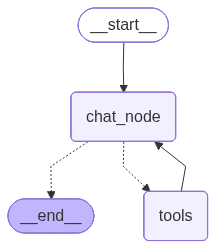

In [44]:
chatbot

In [ ]:
result= chatbot.invoke([HumanMessage(content='WHo is prime minister of UK?')])
inputs = {"messages": [("user", "WHo is prime minister of UK?")]}
for chunk in chatbot.stream(inputs, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

WHo is prime minister of UK?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (tool_duckduckgo_search_zwl0oCCXh4vV7HJpn59K)
 Call ID: tool_duckduckgo_search_zwl0oCCXh4vV7HJpn59K
  Args:
    query: Who is the prime minister of UK


Impersonate 'edge_101' does not exist, using 'random'


================================= Tool Message =================================
Name: duckduckgo_search

UK Prime Minister Keir Starmer has faced calls from some of his own Labour lawmakers to step down in recent days. Jill Lawless, Associated Press UK Prime Minister Starmer averts a leadership challenge for now but remains damaged by Epstein fallout World Feb 10, 2026 10:17 AM EST The prime minister's position is nonetheless quite perilous. Morgan McSweeney, his chief of staff who resigned on Sunday, is not a household name around the world. Or even in Britain. Already weakened by "U-turns" on his agenda, Prime Minister Keir Starmer faced calls to step down over appointing a close friend of Jeffrey Epstein as U.S. ambassador. As Sir Keir Starmer rounds off his first turbulent year in power today, LBC takes a look at the changing face of the Prime Minister over the course of 12 month... and what he could look like in 2026.
================================== Ai Message ================

In [46]:
result['messages'][-1].content

'WHo is prime minister of UK?'

In [47]:
result = chatbot.invoke({'messages':[HumanMessage(content='multiply 3*8')]})
result

{'messages': [HumanMessage(content='multiply 3*8', additional_kwargs={}, response_metadata={}, id='e9f1bd30-e823-42bf-a308-9ecefd85f4c2'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model_name': 'google/gemini-2.5-flash', 'id': 'gen-1771579073-8AdLCxLZ82t6bX7yGFAm', 'created': 1771579073, 'object': 'chat.completion', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'openrouter'}, id='lc_run--019c7a57-6269-7d51-b0d6-44e38f7291ca-0', tool_calls=[{'name': 'calculator', 'args': {'num2': 8, 'operation': 'multiplication', 'num1': 3}, 'id': 'tool_calculator_2kznuYmxPIuZkrDNrAn8', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 84, 'output_tokens': 10, 'total_tokens': 94, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}, 'output_token_details': {'reasoning': 0}}),
  ToolMessage(content="Error invoking tool 'calculator' with kwargs {'num2': 8, 'operation': 'multiplication', 'num1': 3} with error:\n operation: In